In [1]:
import fmdtools.sim.propagate as propagate
import fmdtools.analyze as an
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Urban Drone Demo
## Model Overview
The drone model is defined in `drone_mdl_urban.py`, along with some visualization functions.

In [2]:
from drone_mdl_urban import Drone

In [3]:
mdl = Drone()

This is the model structure:

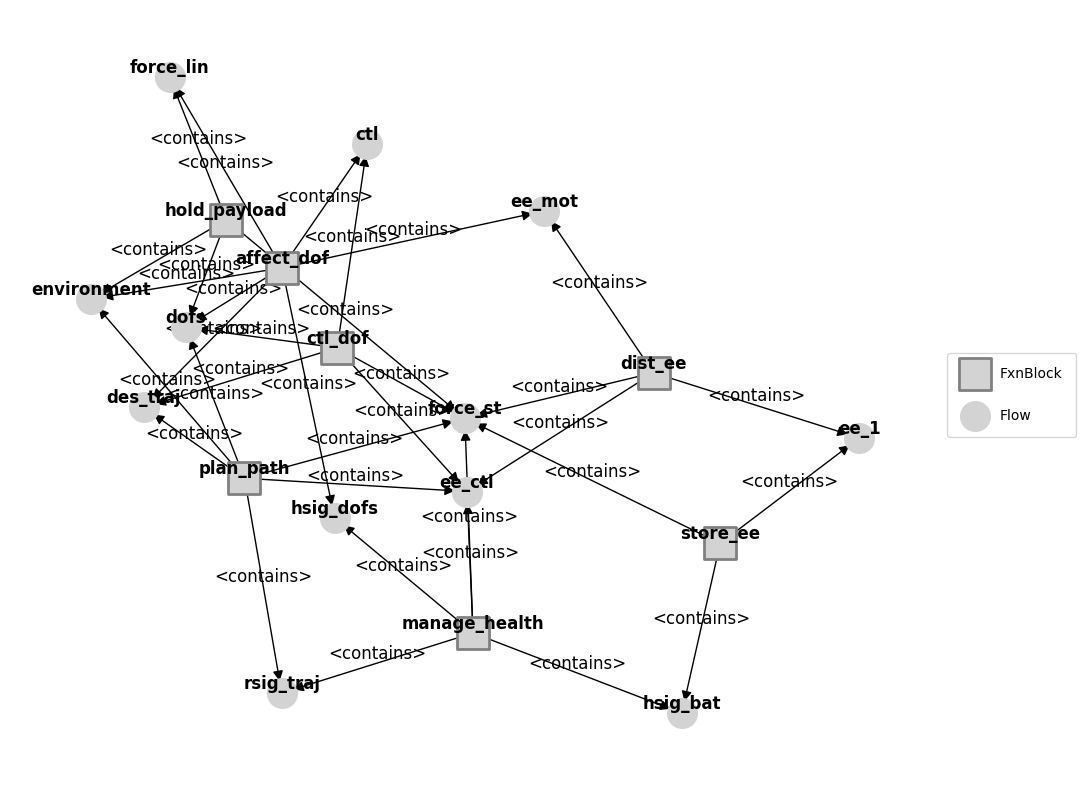

In [4]:
mg = an.graph.ModelGraph(mdl)
fig, ax = mg.draw()

We can also view the grid environment using:

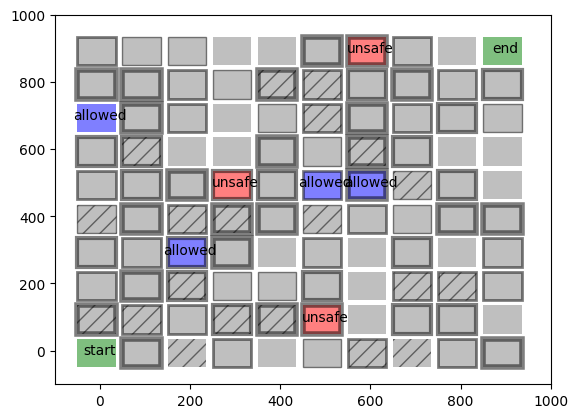

In [5]:
fig, ax = mdl.flows["environment"].show_grid()

Which shows the Start, End, and allowed/unsafe locations in the 1000x1000-m grid. In this display, line thickness corresponds to building height, and hatching corresponds to whether or not the space is occupied. We can also display this using `.show_3d`:

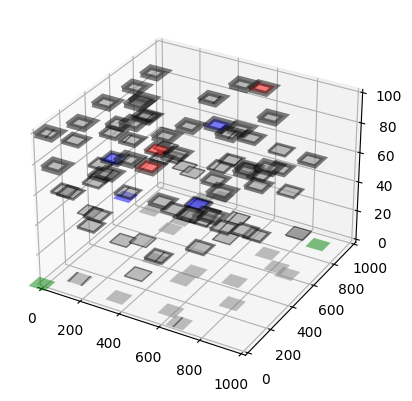

In [6]:
fig, ax = mdl.flows["environment"].show_3d()

## Nominal Simulation

Below we show how this drone performs in the nominal scenario.

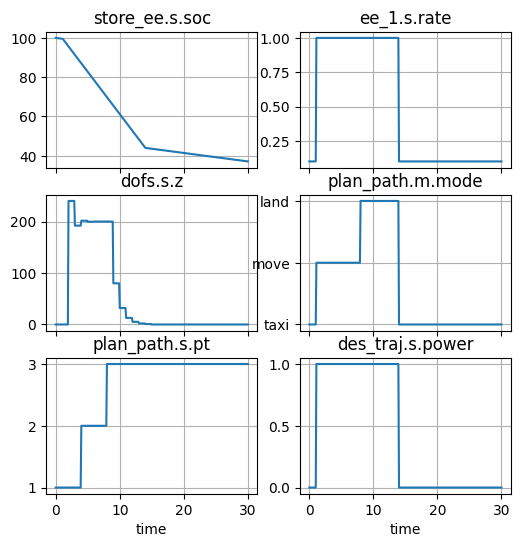

In [7]:
results_nom, hist_nom =propagate.nominal(mdl)
fig, axs = an.plot.hist(hist_nom, "store_ee.s.soc",
                            'ee_1.s.rate',
                            'dofs.s.z',
                            'plan_path.m.mode',
                            'plan_path.s.pt',
                            'des_traj.s.power')

As shown, the flight ends fairly quickly (in 10 minutes), with the drone successively proceeding through points in the flight plan.

We can also view this flightpath in 3-d space using `plot_traj` and `plot_xy`:

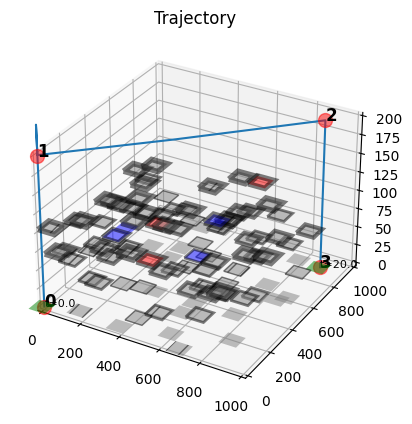

In [8]:
from drone_mdl_urban import plot_traj, plot_xy
fig, ax = plot_traj(hist_nom, mdl)

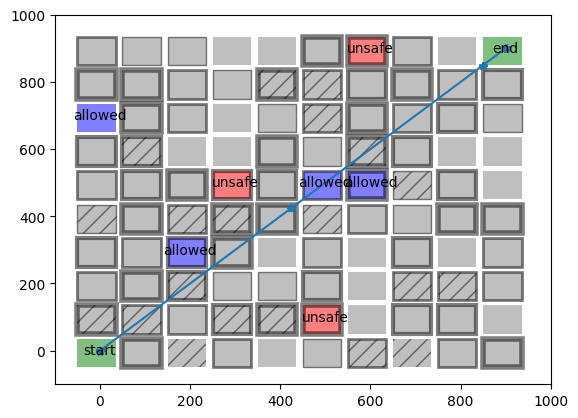

In [9]:
fig, ax = plot_xy(hist_nom, mdl)

As shown, this is a rather simple straight-line path. If we wanted a more complex scenario, we could make the path more complex by adding multiple destinations or planning the path based on allowed flight/landing locations.

As it is, we may also want to adjust the timestep/speed to get more resolution, since the drone only has a few discrete timesteps in the air.

The results for the simulation are:

In [10]:
results_nom

endclass: 
--rate:                              1.0
--cost:                              0.0
--expected cost:                     0.0
--repcost:                             0
--unsafe_flight_time:                  0
--body_strikes:                      0.0
--head_strikes:                      0.0
--property_restrictions:               0
--safecost:                          0.0
--landcost:                            0
--p_safety:                          0.0
--severities: {'hazardous': 0.0, 'minor': 1.0}

## Resilience model
A number of different faults have been implemented in the system.

For example, here we inject a mechanical fault in the left-rear rotor during flight:

In [11]:
mdl.fxns['affect_dof'].m.faultmodes

{'lf_short': Fault(dist=0.1, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lf_openc': Fault(dist=0.1, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lf_ctlup': Fault(dist=0.2, oppvect=[1.0], rcost=500, probtype='rate', units='hr'),
 'lf_ctldn': Fault(dist=0.2, oppvect=[1.0], rcost=500, probtype='rate', units='hr'),
 'lf_ctlbreak': Fault(dist=0.2, oppvect=[1.0], rcost=1000, probtype='rate', units='hr'),
 'lf_mechbreak': Fault(dist=0.1, oppvect=[1.0], rcost=500, probtype='rate', units='hr'),
 'lf_mechfriction': Fault(dist=0.05, oppvect=[1.0], rcost=500, probtype='rate', units='hr'),
 'lf_propwarp': Fault(dist=0.01, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lf_propstuck': Fault(dist=0.02, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lf_propbreak': Fault(dist=0.03, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lr_short': Fault(dist=0.1, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lr_openc': Fault(dist=0.1, oppvec

In [12]:
results_fault, hist_fault =propagate.one_fault(mdl, "affect_dof", "lr_mechbreak", time=2.0)

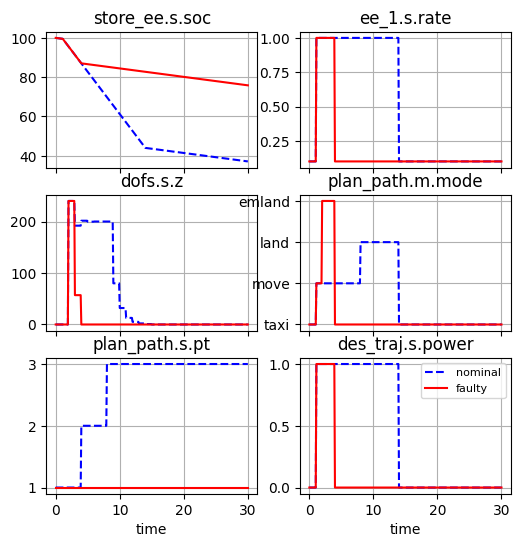

In [13]:
fig, axs = an.plot.hist(hist_fault, "store_ee.s.soc",
                            'ee_1.s.rate',
                            'dofs.s.z',
                            'plan_path.m.mode',
                            'plan_path.s.pt',
                            'des_traj.s.power')

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

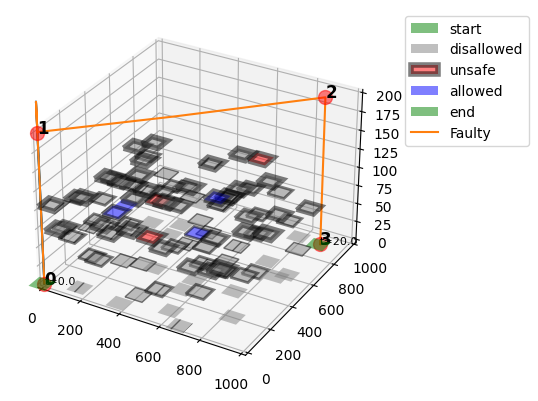

In [14]:
plot_traj(hist_fault, mdl, title="", legend=True)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

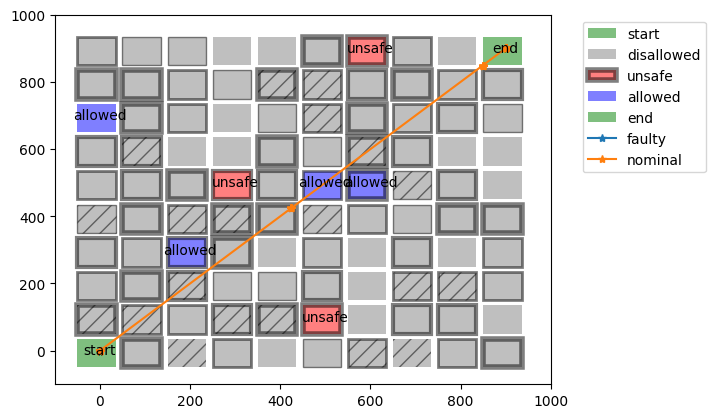

In [15]:
plot_xy(hist_fault, mdl, legend=True)

In [16]:
results_fault

endclass.rate:                       0.5
endclass.cost:                     500.0
endclass.expected cost:       25000000.0
endclass.repcost:                    500
endclass.unsafe_flight_time:           0
endclass.body_strikes:               0.0
endclass.head_strikes:               0.0
endclass.property_restrictions:        0
endclass.safecost:                   0.0
endclass.landcost:                     0
endclass.p_safety:                   0.0
endclass.severities: {'hazardous': 0.0, 'minor': 0.5}

Here we inject a large list of faults in the system and evaluate their relative consequences in terms of metrics calculated in find_classification:

In [17]:
phases, modephases = hist_nom.get_modephases()
phases

{'manage_health': {'nominal': [0.0, 30.0]},
 's1p1': {'nominal': [0.0, 30.0]},
 'store_ee': {'nominal': [0.0, 30.0]},
 'dist_ee': {'nominal': [0.0, 30.0]},
 'lf': {'nominal': [0.0, 30.0]},
 'lr': {'nominal': [0.0, 30.0]},
 'rf': {'nominal': [0.0, 30.0]},
 'rr': {'nominal': [0.0, 30.0]},
 'affect_dof': {'nominal': [0.0, 30.0]},
 'ctl_dof': {'nominal': [0.0, 30.0]},
 'vision': {'nominal': [0.0, 30.0]},
 'plan_path': {'taxi': [0.0, 1.0],
  'move': [1.1, 7.9],
  'land': [8.0, 13.9],
  'taxi1': [14.0, 30.0]},
 'hold_payload': {'nominal': [0.0, 30.0]}}

In [18]:
from fmdtools.sim.approach import SampleApproach

from drone_mdl_urban import make_move_quad
move_quad=make_move_quad(hist_nom, phases['plan_path']['move'])
app = SampleApproach(mdl, phases=phases, modephases=modephases,
                     sampparams = {('PlanPath','move'): move_quad})
app

C:\Users\dhulse\AppData\Local\Temp\1\ipykernel_1396\3634453612.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  move_quad=make_move_quad(hist_nom, phases['plan_path']['move'])


SampleApproach for Drone model with 59 modes: 
 -manage_health: lostfunction
 -store_ee: nocharge
 -store_ee: lowcharge
 -store_ee: s1p1_short
 -store_ee: s1p1_degr
 -store_ee: s1p1_break
 -store_ee: s1p1_nocharge
 -store_ee: s1p1_lowcharge
 -dist_ee: short
 -dist_ee: degr
 -...more
None joint modes (0 combinations), 
in 7 phases: 
 -('plan_path', 'taxi'): [0.0, 1.0]
 -('plan_path', 'move'): [1.1, 7.9]
 -('plan_path', 'land'): [8.0, 13.9]
 -('plan_path', 'taxi1'): [14.0, 30.0]
 -('global', 'ascend'): [0, 0]
 -('global', 'forward'): [1, 11]
 -('global', 'taxi'): [12, 20] 
sampled at 7 times: 
 -[0.0, 0.5, 4.5, 6.0, 11.0, 16.0, 22.0]
resulting in 67 total fault scenarios.

In [19]:
endresults, hists = propagate.approach(mdl, app, staged=False)

SCENARIOS COMPLETE: 100%|██████████| 67/67 [00:20<00:00,  3.22it/s]


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

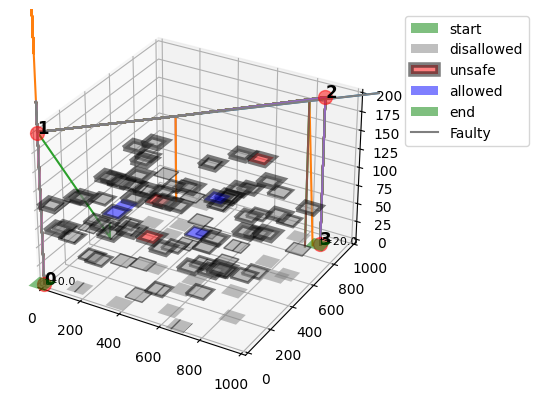

In [20]:
plot_traj(hists, mdl, title="", legend=True)

In [21]:
hists.get("nominal")

i.landed:                     array(301)
fxns.manage_health.m          array(301)
fxns.manage_health.m.mode:    array(301)
fxns.store_ee.c.components.s1p1.s.soc: array(301)
fxns.store_ee.c.components.s1p1.s.ee_e: array(301)
fxns.store_ee.c.components.s1p1.s.e_t: array(301)
fxns.store_ee.c.comp          array(301)
fxns.store_ee.c.comp          array(301)
fxns.store_ee.c.comp          array(301)
fxns.store_ee.c.comp          array(301)
fxns.store_ee.c.comp          array(301)
fxns.store_ee.c.components.s1p1.m.mode: array(301)
fxns.store_ee.s.soc:          array(301)
fxns.store_ee.m.faults.nocharge: array(301)
fxns.store_ee.m.faults.lowcharge: array(301)
fxns.store_ee.m.faults.s1p1_short: array(301)
fxns.store_ee.m.faults.s1p1_degr: array(301)
fxns.store_ee.m.faults.s1p1_break: array(301)
fxns.store_ee.m.faults.s1p1_nocharge: array(301)
fxns.store_ee.m.faults.s1p1_lowcharge: array(301)
fxns.store_ee.m.mode:         array(301)
fxns.dist_ee.s.ee_tr:         array(301)
fxns.dist_ee.s.ee_te: 

In [22]:
    statsfmea = an.tabulate.fmea(endresults, app, group_by='fxnfault',
                                 weight_metrics=['rate'],
                                 avg_metrics=['unsafe_flight_time', 'cost', 'repcost',
                                              'landcost', 'body_strikes',
                                              'head_strikes', 'property_restrictions'],
                                 sort_by='cost')
statsfmea

rate  unsafe_flight_time  \
plan_path     vision_lack_of_detection    5.750000e-01                 0.0   
              vision_undesired_detection  5.750000e-01                 0.0   
dist_ee       short                       1.016667e-06                 0.0   
              break                       6.777778e-07                 0.0   
hold_payload  deform                      2.388889e-07                 0.0   
              break                       5.972222e-08                 0.0   
plan_path     degloc                      2.610000e-06                 0.0   
ctl_dof       degctl                      2.610000e-06                 0.0   
plan_path     noloc                       6.525000e-07                 0.0   
dist_ee       degr                        1.694444e-06                 0.0   
ctl_dof       noctl                       6.525000e-07                 0.0   
manage_health lostfunction                1.493056e-08                 0.0   
store_ee      s1p1_nocharge               2.000000e-05                 0.0   
              lowcharge                   2.257500e-05                 0.0   
              s1p1_lowcharge              1.246667e-05                 0.0   
              nocharge                    6.450000e-06                 0.0   
              s1p1_short                  5.972222e-06                 0.0   
              s1p1_break                  5.972222e-06                 0.0   
              s1p1_degr                   5.972222e-06                 0.0   
affect_dof    lf_openc                    0.000000e+00                 0.0   
              rr_ctldn                    0.000000e+00                 0.0   
              rf_propwarp                 0.000000e+00                 0.0   
              rf_propstuck                0.000000e+00                 0.0   
              rf_propbreak                0.000000e+00                 0.0   
              rr_short                    0.000000e+00                 0.0   
              rr_openc                    0.000000e+00                 0.0   
              rr_ctlup                    0.000000e+00                 0.0   
              rr_mechfriction             0.000000e+00                 0.0   
              rr_ctlbreak                 0.000000e+00                 0.0   
              rr_mechbreak                0.000000e+00                 0.0   
              rf_mechbreak                0.000000e+00                 0.0   
              rr_propwarp                 0.000000e+00                 0.0   
              rr_propstuck                0.000000e+00                 0.0   
              rr_propbreak                0.000000e+00                 0.0   
              lf_short                    0.000000e+00                 0.0   
              rf_mechfriction             0.000000e+00                 0.0   
              rf_ctlbreak                 0.000000e+00                 0.0   
              lf_ctlup                    0.000000e+00                 0.0   
              rf_ctldn                    0.000000e+00                 0.0   
              lf_ctldn                    0.000000e+00                 0.0   
              lf_ctlbreak                 0.000000e+00                 0.0   
              lf_mechbreak                0.000000e+00                 0.0   
              lf_mechfriction             0.000000e+00                 0.0   
              lf_propwarp                 0.000000e+00                 0.0   
              lf_propstuck                0.000000e+00                 0.0   
              lf_propbreak                0.000000e+00                 0.0   
              lr_short                    0.000000e+00                 0.0   
              lr_openc                    0.000000e+00                 0.0   
              lr_ctlup                    0.000000e+00                 0.0   
              lr_ctldn                    0.000000e+00                 0.0   
              lr_ctlbreak                 0.000000e+00                 0